# Project: Identify Customer Segments

In this project, I apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments then are used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I use has been provided by Udacity's partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I use this information to cluster the general population into groups with similar demographic properties. Then, I see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [4]:
# Check the structure of the data after it's loaded
print(str(len(azdias)) + ' observations')
azdias.head(5)

891221 observations


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I use this file to make cleaning decisions during this stage of the project.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object.

In [5]:
# feature summary file
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [6]:
# Identify missing or unknown data values and convert them to NaNs.

for col in range(len(azdias.columns)):
    varname = azdias.columns[col]
    miss_vals = feat_info[feat_info["attribute"] == varname].loc[:,'missing_or_unknown'].to_string()
    if re.findall(r'(?<=\[).+?(?=\])', miss_vals) != []:
        miss_vals = re.findall(r'(?<=\[).+?(?=\])', miss_vals)[0].split(',')
        for val in miss_vals:
            try:
                val = int(val)
            except:
                val = val
            azdias[varname][azdias[varname] == val] = np.nan    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing.

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

share_missing = azdias.apply(lambda x: sum(pd.isnull(x))/len(x), axis = 0)

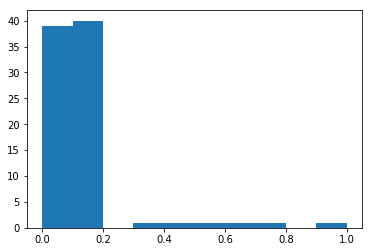

In [8]:
plt.hist(share_missing, bins = 10);

In [9]:
# Investigate the percent of missing data in each column.

for col in range(len(share_missing)):
    if share_missing[col] > 0.20:
        print(azdias.columns[col], np.round(share_missing[col], 2))

AGER_TYP 0.77
GEBURTSJAHR 0.44
TITEL_KZ 1.0
ALTER_HH 0.35
KK_KUNDENTYP 0.66
KBA05_BAUMAX 0.53


In [10]:
# Remove the outlier columns from the dataset.

azdias0 = azdias.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis = 1)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, I perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, I see some groups of points that have a very different numbers of missing values.

In [11]:
# How much data is missing in each row of the dataset?

share_missing_rows = azdias0.apply(lambda x: sum(pd.isnull(x))/len(x), axis = 1)

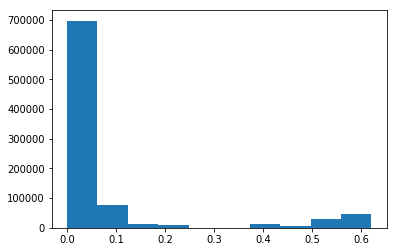

In [12]:
plt.hist(share_missing_rows, bins = 10);

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_miss = azdias0[share_missing_rows>0.3]
azdias_nonmiss = azdias0[share_missing_rows<0.3]

In [14]:
# Percent of rows kept for analysis

len(azdias_nonmiss)/len(azdias0)

0.8952179089137262

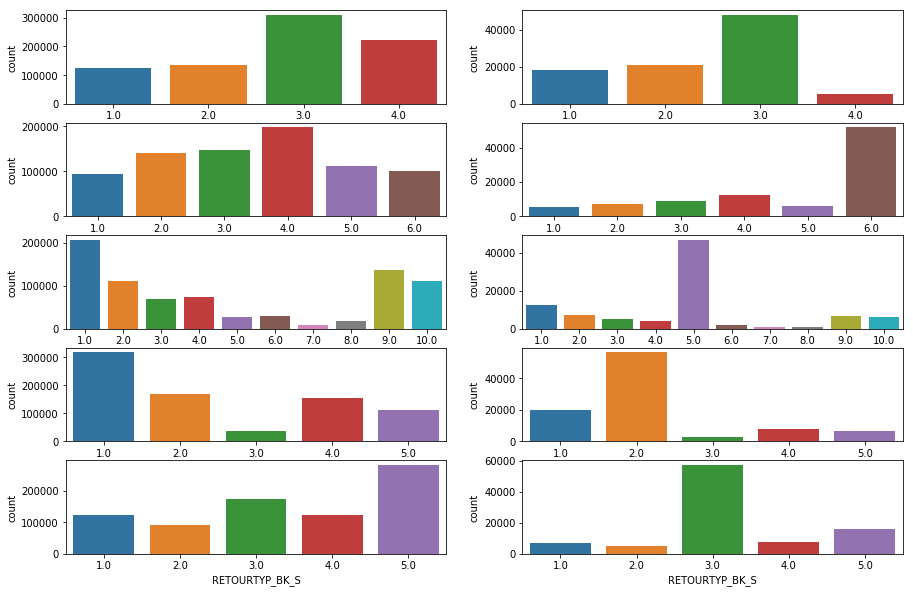

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = [15, 10])
sns.countplot(azdias_nonmiss['ALTERSKATEGORIE_GROB'], ax = axes[0, 0])
sns.countplot(azdias_miss['ALTERSKATEGORIE_GROB'], ax = axes[0, 1])
sns.countplot(azdias_nonmiss['CJT_GESAMTTYP'], ax = axes[1, 0])
sns.countplot(azdias_miss['CJT_GESAMTTYP'], ax = axes[1, 1])
sns.countplot(azdias_nonmiss['LP_STATUS_FEIN'], ax = axes[2, 0])
sns.countplot(azdias_miss['LP_STATUS_FEIN'], ax = axes[2, 1])
sns.countplot(azdias_nonmiss['LP_STATUS_GROB'], ax = axes[3, 0])
sns.countplot(azdias_miss['LP_STATUS_GROB'], ax = axes[3, 1])
sns.countplot(azdias_nonmiss['RETOURTYP_BK_S'], ax = axes[4, 0])
sns.countplot(azdias_miss['RETOURTYP_BK_S'], ax = axes[4, 1]);

#### Discussion 1.1.3: Assess Missing Data in Each Row

In general, the distributions between the data with many missing values from the data with few missing values. For this reason, it may be helpful to conduct a sensitivity analysis using a different threshold for dividing the data into two and see if the resulting segments change.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [16]:
# How many features are there of each data type?

feat_info.groupby('type')['type'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, I would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, I would perform one of the following:
- For binary (two-level) categoricals that take numeric values, I can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, I need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables, or (to keep things straightforward) just drop them from the analysis.

In [17]:
# Categorical Features

feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

azdias0 = azdias_nonmiss
for col in range(len(azdias0.columns)):
    if azdias0.columns[col] in list(feat_info[feat_info['type'] == 'categorical']['attribute']):
        print(azdias0.columns[col], ":", azdias0.iloc[:, col].unique())

ANREDE_KZ : [2 1]
CJT_GESAMTTYP : [  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP : [1 6 5 2 4 3]
GFK_URLAUBERTYP : [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
GREEN_AVANTGARDE : [0 1]
LP_FAMILIE_FEIN : [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB : [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN : [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB : [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ : [  1.   3.   2.  nan]
SHOPPER_TYP : [  3.   2.   1.   0.  nan]
SOHO_KZ : [ 1.  0.]
VERS_TYP : [  2.   1.  nan]
ZABEOTYP : [5 3 4 1 6 2]
GEBAEUDETYP : [ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ : ['W' 'O']
CAMEO_DEUG_2015 : ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015 : ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [19]:
# Drop redundant fields

azdias1 = azdias0.drop(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'GEBAEUDETYP'], axis = 1)
azdias1 = azdias1.drop(azdias1.columns[azdias1.columns.str.startswith('FINANZ_')], axis = 1)

In [20]:
# List of categorical variables to perform one hot code

cols_categorical = []
for col in range(len(azdias1.columns)):
    if azdias1.columns[col] in list(feat_info[feat_info['type'] == 'categorical']['attribute']):
        cols_categorical.append(azdias1.columns[col])

In [21]:
# Do not one hot code categorical variables that do appear to be ordinal or binary

cols_categorical.remove('LP_FAMILIE_GROB')
cols_categorical.remove('LP_STATUS_GROB')
cols_categorical.remove('GREEN_AVANTGARDE')
cols_categorical.remove('SOHO_KZ')
cols_categorical.remove('ANREDE_KZ')
cols_categorical.remove('OST_WEST_KZ')
cols_categorical.remove('VERS_TYP')
cols_categorical.remove('SHOPPER_TYP')
cols_categorical.remove('ZABEOTYP')

In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.

dummies = pd.get_dummies(azdias1[cols_categorical].astype(str))
azdias2 = azdias1.drop(cols_categorical, axis = 1)
azdias3 = pd.concat([azdias2, dummies], axis = 1)

#### Discussion 1.2.1: Re-Encode Categorical Features

Approximately 20 columns have categorical features. Among them, I dropped following columns, 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', and 'CAMEO_DEU_2015'. The reason is because there are other fields that already capture the information from these columns with more brief and concise categories.

I chose to create multiple dummary variables for the remaining categorical variables. However, I kept some variables as they are if they appear to be categorical features or binary features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [23]:
# Mixed-type features

cols_mixed = []
for col in range(len(azdias3.columns)):
    if azdias3.columns[col] in list(feat_info[feat_info['type'] == 'mixed']['attribute']):
        print(azdias3.columns[col])
        cols_mixed.append(azdias3. columns[col])

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
WOHNLAGE
CAMEO_INTL_2015
PLZ8_BAUMAX


In [24]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias3['generation'] = np.where(azdias3['PRAEGENDE_JUGENDJAHRE']<2, 1,
                                 np.where(azdias3['PRAEGENDE_JUGENDJAHRE']<4, 2,
                                          np.where(azdias3['PRAEGENDE_JUGENDJAHRE']<7, 3, 
                                                   np.where(azdias3['PRAEGENDE_JUGENDJAHRE']<10, 4, 
                                                            np.where(azdias3['PRAEGENDE_JUGENDJAHRE']<13, 5, 
                                                                     np.where(azdias3['PRAEGENDE_JUGENDJAHRE']<15, 6, np.nan))))))

azdias3['mainstream'] = np.where(azdias3['PRAEGENDE_JUGENDJAHRE'].isin([1, 3, 5, 8, 10, 12, 14]), 1, 0)
azdias4 = azdias3.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)

In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias4['wealth'] = azdias4['CAMEO_INTL_2015'].astype(float) // 10
azdias4['life_stage'] = azdias4['CAMEO_INTL_2015'].astype(float) % 10
azdias5 = azdias4.drop(['CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis = 1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I extracted generation and mainstream variables from "PRAEGENDE_JUGENDJAHRE" and wealth and life stage variables from "CAMEO_INTL_2015". I dropped two columns, "LP_LEBENSPHASE_FEIN" and "LP_LEBENSPHASE_GROB" that have information contained in other columns such as "LP_FAMILIE_GROB" or "LP_FAMILIE_GROB". I kept "WOHNLAGE" and "PLZ8_BAUMAX" as is because it appears to be an ordinal variable (on the contrary to the description in the field description file).

In [29]:
# Additional cleaning

azdias5['ANREDE_KZ'] = azdias5['ANREDE_KZ'] - 1
azdias5['OST_WEST_KZ'] = np.where(azdias5['OST_WEST_KZ']=='W', 1, 0)
azdias5['VERS_TYP'] = azdias5['VERS_TYP'] - 1
azdias5 = azdias5.drop(azdias5.columns[azdias5.columns.str.endswith('nan')], axis = 1)

### Step 1.3: Create a Cleaning Function

Even though I've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that I will need to perform the same cleaning steps on the customer demographics data. In this substep, I complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above.

In [30]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col in range(len(df.columns)):
        varname = df.columns[col]
        miss_vals = feat_info[feat_info["attribute"] == varname].loc[:,'missing_or_unknown'].to_string()
        if re.findall(r'(?<=\[).+?(?=\])', miss_vals) != []:
            miss_vals = re.findall(r'(?<=\[).+?(?=\])', miss_vals)[0].split(',')
            for val in miss_vals:
                try:
                    val = int(val)
                except:
                    val = val
                df[varname][df[varname] == val] = np.nan

    # Remove selected columns and rows, ...
    df0 = df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis = 1)
    df_share_missing_rows = df0.apply(lambda x: sum(pd.isnull(x))/len(x), axis = 1)
    df_miss = df0[df_share_missing_rows>0.3]
    df_nonmiss = df0[df_share_missing_rows<0.3]
    
    # Select, re-encode, and engineer column values.
    df1 = df_nonmiss.drop(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'GEBAEUDETYP'], axis = 1)
    df1 = df1.drop(df1.columns[df1.columns.str.startswith('FINANZ_')], axis = 1)
    df_dummies = pd.get_dummies(df1[cols_categorical].astype(str))
    df2 = df1.drop(cols_categorical, axis = 1)
    df3 = pd.concat([df2, df_dummies], axis = 1)

    df3['generation'] = np.where(df3['PRAEGENDE_JUGENDJAHRE']<2, 1,
                                 np.where(df3['PRAEGENDE_JUGENDJAHRE']<4, 2,
                                          np.where(df3['PRAEGENDE_JUGENDJAHRE']<7, 3, 
                                                   np.where(df3['PRAEGENDE_JUGENDJAHRE']<10, 4, 
                                                            np.where(df3['PRAEGENDE_JUGENDJAHRE']<13, 5, 
                                                                     np.where(df3['PRAEGENDE_JUGENDJAHRE']<15, 6, np.nan))))))

    df3['mainstream'] = np.where(df3['PRAEGENDE_JUGENDJAHRE'].isin([1, 3, 5, 8, 10, 12, 14]), 1, 0)
    df4 = df3.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
    
    df4['wealth'] = df4['CAMEO_INTL_2015'].astype(float) // 10
    df4['life_stage'] = df4['CAMEO_INTL_2015'].astype(float) % 10
    df5 = df4.drop(['CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis = 1)
    
    df5['ANREDE_KZ'] = df5['ANREDE_KZ'] - 1
    df5['OST_WEST_KZ'] = np.where(df5['OST_WEST_KZ']=='W', 1, 0)
    df5['VERS_TYP'] = df5['VERS_TYP'] - 1
    df5 = df5.drop(df5.columns[df5.columns.str.endswith('nan')], axis = 1)
    
    # Return the cleaned dataframe.
    return df5

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before I apply dimensionality reduction techniques to the data, I need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, I need to make sure that I've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. I might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.

In [31]:
# Impute the NaN values using median

from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')
imputer_fitted = imputer.fit(azdias5)
azdias6 = imputer_fitted.transform(azdias5)
azdias7 = pd.DataFrame(azdias6, columns = azdias5.columns)

In [32]:
# Apply feature scaling to the general population demographics data.

cols_numeric = []
for col in range(len(azdias7.columns)):
    if azdias7.columns[col] in list(feat_info[feat_info['type'].isin(['numeric', 'ordinal'])]['attribute']):
        cols_numeric.append(azdias7.columns[col])
        
cols_numeric.append('LP_FAMILIE_GROB')
cols_numeric.append('LP_STATUS_GROB')
cols_numeric.append('generation')
cols_numeric.append('wealth')
cols_numeric.append('life_stage')
cols_numeric.append('PLZ8_BAUMAX')
cols_numeric.append('WOHNLAGE')
cols_numeric.append('SHOPPER_TYP')
cols_numeric.append('ZABEOTYP')

In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler_fitted = scaler.fit(azdias7[cols_numeric])
cols_scaled = scaler_fitted.transform(azdias7[cols_numeric])
cols_scaled = pd.DataFrame(cols_scaled, columns = cols_numeric)
azdias8 = pd.concat([azdias7.drop(cols_numeric, axis = 1), cols_scaled], axis = 1)

In [34]:
azdias9 = azdias8.drop(['FINANZTYP_6'], axis = 1)

### Discussion 2.1: Apply Feature Scaling

I imputed missing values by applying the median value for each feature. I used median instead of mean as median is more robust to outliers. After then, I scaled values for ordinal and numeric features. I used the min-max scaler instead of the standard scaler because this allows putting all variables on the same scale from 0 to 1.

Additionally, I dropped the field 'FINANZTYP_6' as it represents the inconspicuous type for financial type and does not give meaningful information.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- I use sklearn's PCA class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, I do not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Then, I check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Based on what I find, I select a value for the number of transformed features I will retain for the clustering part of the project.
- Once I have made a choice for the number of components to keep, I re-fit a PCA instance to perform the decided-on transformation.

In [35]:
# Apply initial PCA to the data.

from sklearn.decomposition import PCA

pca = PCA(n_components = 50)
pca_fitted = pca.fit(azdias9)
azdias10 = pca_fitted.transform(azdias9)

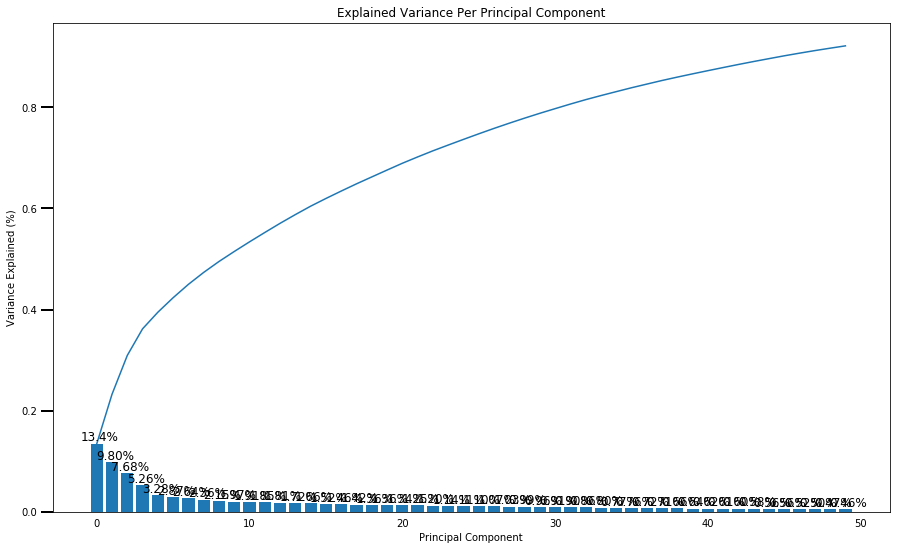

In [36]:
# Investigate the variance accounted for by each principal component.

num_components = len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(15, 9))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(num_components):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [39]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 10)
pca_fitted = pca.fit(azdias9)
azdias10 = pca_fitted.transform(azdias9)

In [40]:
# Percent of variance explained by new components

pca.explained_variance_ratio_.sum()

0.51445588326994474

### Discussion 2.2: Perform Dimensionality Reduction

I reduced 90 features to 10 features. The new features explain approximately 51% of the variance from all 90 features.

### Step 2.3: Interpret Principal Components

Now that I have transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

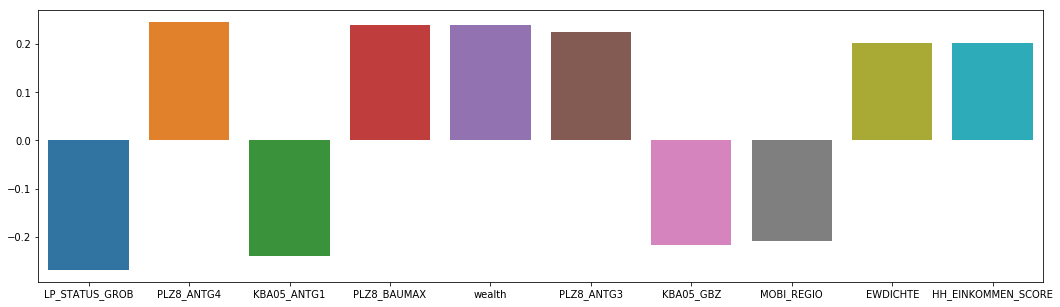

In [41]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

dimension = pd.DataFrame(pca.components_, columns = azdias9.columns)

def plot_pca(component_num):
    fig, ax = plt.subplots(figsize = [18, 5])
    dimension_1 = dimension.iloc[component_num, :]
    dimension_1a = dimension_1[abs(dimension_1).sort_values(ascending = False)[:10].keys()]
    sns.barplot(dimension_1a.keys(), dimension_1a.values, axes = ax)

plot_pca(0)

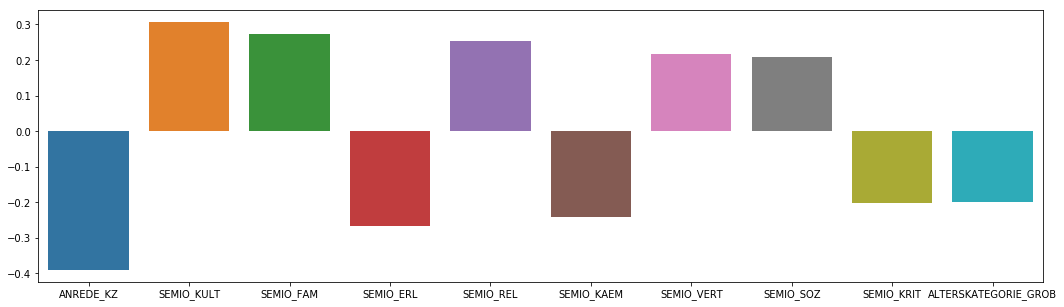

In [42]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_pca(1)

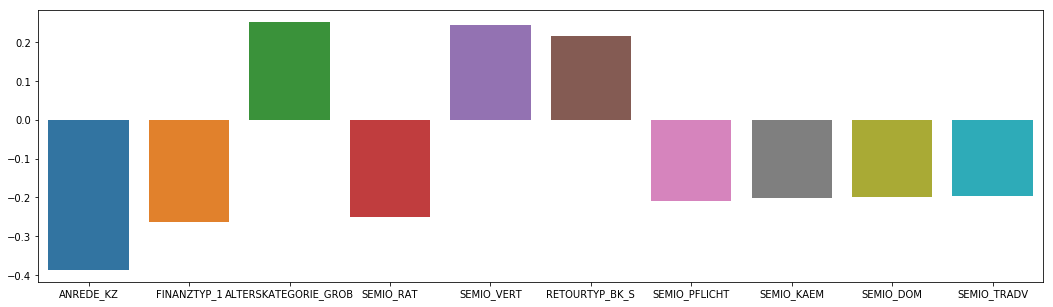

In [43]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_pca(2)

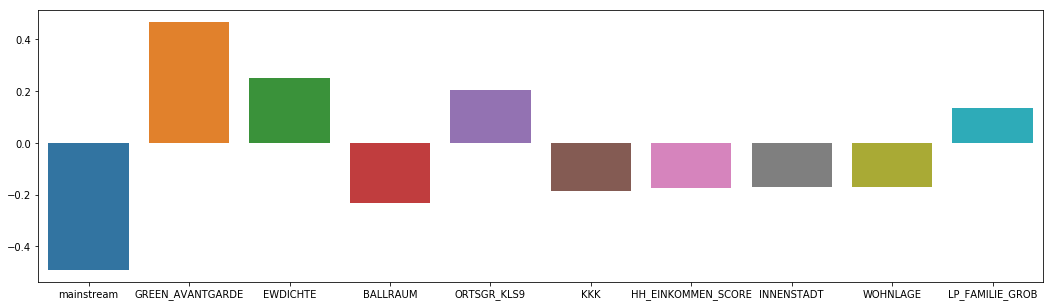

In [44]:
# Map weights for the fourth principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_pca(3)

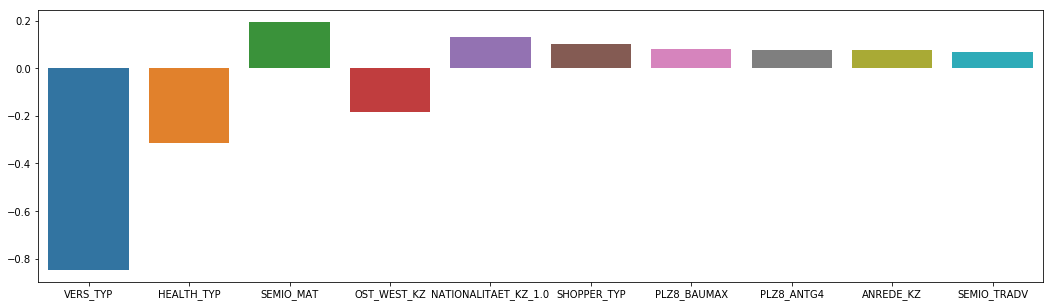

In [45]:
# Map weights for the fifth principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_pca(4)

### Discussion 2.3: Interpret Principal Components

PCA Var 0: Less affluent customers who tend to live in buildings with families of multiple members

PCA Var 1: Cultural, family-oriented, non-event-driven male customers

PCA Var 2: Old male customers who tend to be more rational

PCA Var 3: Avantgarde customers who live in population-dense areas near urban centers

PCA Var 4: Customers who are accepting risk and have less interest in health

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

In [48]:
from sklearn.cluster import KMeans

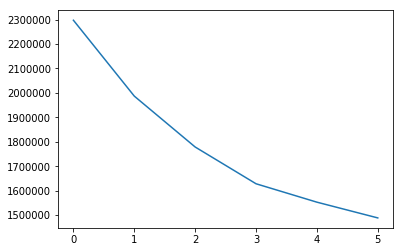

In [50]:
scores = []

for num in [4, 6, 8, 10, 12, 14]:
    kmeans = KMeans(n_clusters = num)

    # run k-means clustering on the data and...
    fitted = kmeans.fit(azdias10)

    # compute the average within-cluster distances.
    scores.append(abs(fitted.score(azdias10)))

plt.plot(scores);

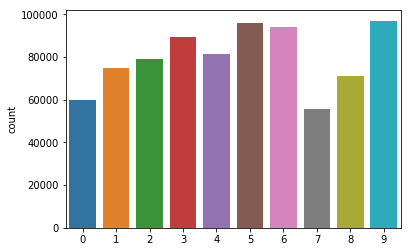

In [52]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 10)
fitted = kmeans.fit(azdias10)
kmeans_cluster_label = fitted.predict(azdias10)
sns.countplot(kmeans_cluster_label);

### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. In the last step of the project, I will interpret how the general population fits apply to the customer data.

- I apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function created earlier.
- I use the sklearn objects from the general demographics data, and apply their transformations to the customers data.

In [53]:
# Load in the customer demographics data.

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [54]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers0 = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [55]:
# Apply feature scaling and trained PCA to the customers data

customers1 = imputer_fitted.transform(customers0)
customers1 = pd.DataFrame(customers1, columns = customers0.columns)
customers_scaled = scaler_fitted.transform(customers1[cols_numeric])
customers_scaled = pd.DataFrame(customers_scaled, columns = cols_numeric)
customers2 = pd.concat([customers1.drop(cols_numeric, axis = 1), customers_scaled], axis = 1)
customers3 = customers2.drop(['FINANZTYP_6'], axis = 1)
customers4 = pca_fitted.transform(customers3)

In [56]:
# Predict the clusters for customers data

kmeans_cluster_label_customers = fitted.predict(customers4)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company.

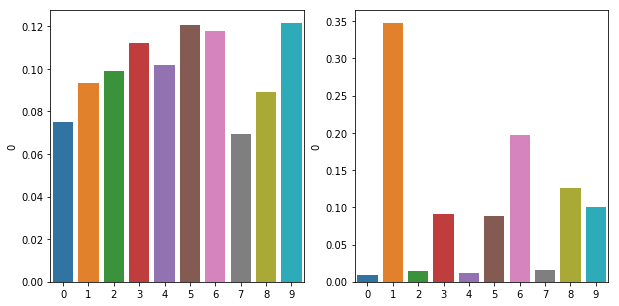

In [57]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

kmeans_cluster_label0 = pd.DataFrame(kmeans_cluster_label)[0]
kmeans_cluster_label1 = kmeans_cluster_label0.value_counts().sort_index()/kmeans_cluster_label0.value_counts().sum()

kmeans_cluster_label_customers0 = pd.DataFrame(kmeans_cluster_label_customers)[0]
kmeans_cluster_label_customers1 = kmeans_cluster_label_customers0.value_counts().sort_index()/kmeans_cluster_label_customers0.value_counts().sum()

fig, axes = plt.subplots(ncols = 2, figsize = [10, 5])
sns.barplot(kmeans_cluster_label1.index, kmeans_cluster_label1, ax = axes[0])
sns.barplot(kmeans_cluster_label_customers1.index, kmeans_cluster_label_customers1, ax = axes[1]);

In [58]:
# Overrepresented customer groups have negative numbers; underrepresented customer groups have positive numbers

print(kmeans_cluster_label1 - kmeans_cluster_label_customers1)

0    0.066637
1   -0.253987
2    0.084847
3    0.021684
4    0.090457
5    0.032011
6   -0.078955
7    0.053073
8   -0.037461
9    0.021693
Name: 0, dtype: float64


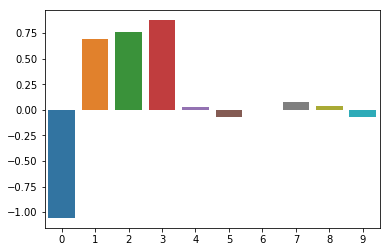

In [59]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

num = 1
centroid = fitted.cluster_centers_[num]
sns.barplot([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], centroid);

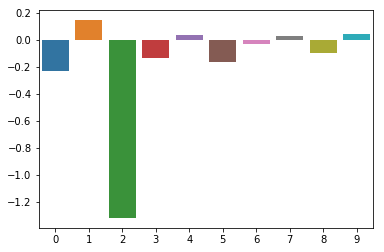

In [61]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

num = 2
centroid = fitted.cluster_centers_[num]
sns.barplot([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], centroid);

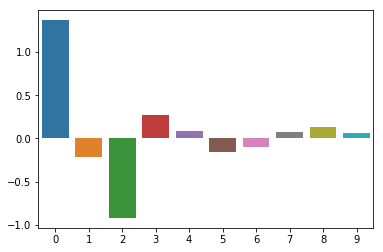

In [62]:
num = 4
centroid = fitted.cluster_centers_[num]
sns.barplot([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], centroid);

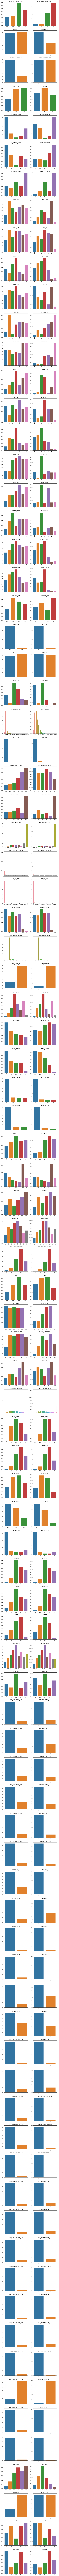

In [63]:
# Draw plots of each variable for the two groups to confirm the trends

fig, axes = plt.subplots(ncols = 2, nrows = 91, figsize = (10, 500))

for i in range(len(azdias5.columns)):
    all_stat = azdias5.iloc[:, i].value_counts(normalize = True).sort_index()
    cust_stat = customers0.iloc[:, i].value_counts(normalize = True).sort_index()
    sns.barplot(all_stat.index, all_stat.values, ax = axes[i, 0]).set_title(azdias5.columns[i])
    sns.barplot(cust_stat.index, cust_stat.values, ax = axes[i, 1]).set_title(azdias5.columns[i])

### Discussion 3.3: Compare Customer Data to Demographics Data

Overrepresented customers are in cluster 1. Customers in cluster 1 are likely to be highly affluent, cultural, family-oriented and old rational male customers who identify themselves as belonging to mainstream.

Underrepresented customers are in clusters 2 and 4. Customers in cluster 6 are most likely young female customers who tend to be less rational. Customers in cluster 4 are less affluent customers who are also likely likely young female customers who tend to be less rational.

PCA Var 0: Less affluent customers who tend to live in buildings with families of multiple members

PCA Var 1: Cultural, family-oriented, non-event-driven male customers

PCA Var 2: Old male customers who tend to be more rational

PCA Var 3: Avantgarde customers who live in population-dense areas near urban centers

PCA Var 4: Customers who are accepting risk and have less interest in health